In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numba 
from matplotlib.animation import FuncAnimation

In [2]:
import src.solutions as solutions
import src.visualizations as visualizations

## Part 1

first draft on assignment 1a, wrote it as an iterative scheme over time and space, saving the two previous time values for the computation of the next time point

The discretized wave equation becomes (with functions from solutions): 

time_approx_1a(deltat, time, func, x) = c^2* spat_approx_1a(deltax, time, func, x, L)

you can rewrite this to get the values of the next time point

### B

Euler's method 

f_x+1 = f_x + h * f'_x

(c*delta t)/delta x < 1 for stable computation 
looking at this method, you can derive that in the first two time-points, the function follows the exact same curve as the derivative (f'_x) is 0

In [ ]:
#choose out of options 1, 2 or 3
overall_solutions_one, xs = solutions.one_b_wrapper(1)
overall_solutions_two, _ = solutions.one_b_wrapper(2)
overall_solutions_three, _ = solutions.one_b_wrapper(3)

overall_solutions = [overall_solutions_one, overall_solutions_two, overall_solutions_three]

KeyboardInterrupt: 

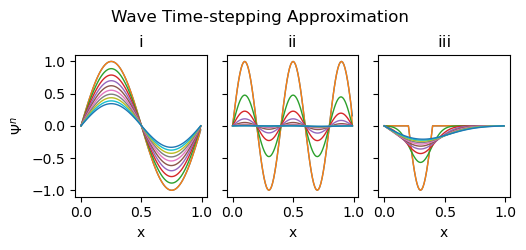

In [5]:
visualizations.visualization_1b(overall_solutions, xs)

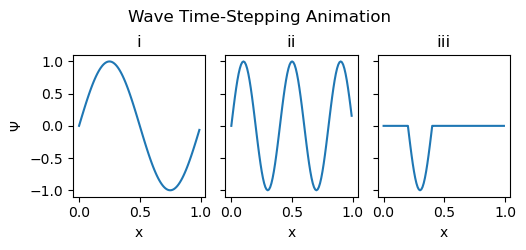

MovieWriter ffmpeg unavailable; using Pillow instead.


KeyboardInterrupt: 

In [6]:
L = 1
N = 100
c = 1
deltat= 0.001
visualizations.animate_1c(L, N, c, deltat)
# animate_1c(L, N, c, deltat)


The equations for the boundaries:

c^(k+1)_(0, j) = 1 -> top row <br>
c^(k+1)_(N-1, j) = 0 -> bottom row <br>
c^(k+1)_(i, 0) = c^(k+1)_(i, N - 2) -> first column <br>
c^(k+1)_(i, -1) = c^(k+1)_(i, 1) -> last column <br>

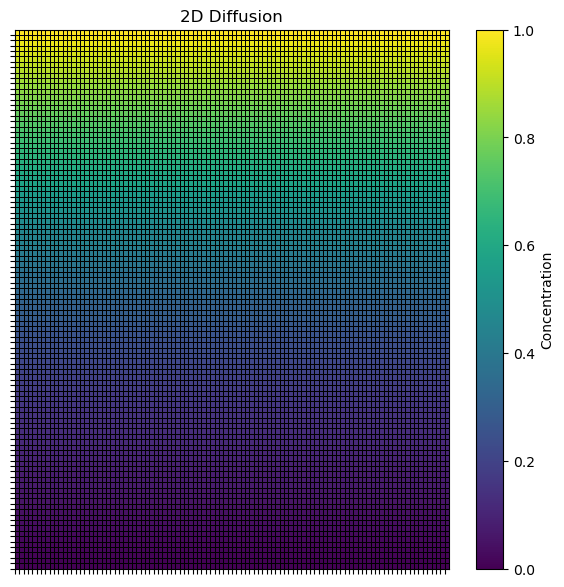

In [4]:
solutions.run_diffusion()

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x11f4ced40> (for post_execute):


TypeError: 'numpy.ndarray' object is not callable

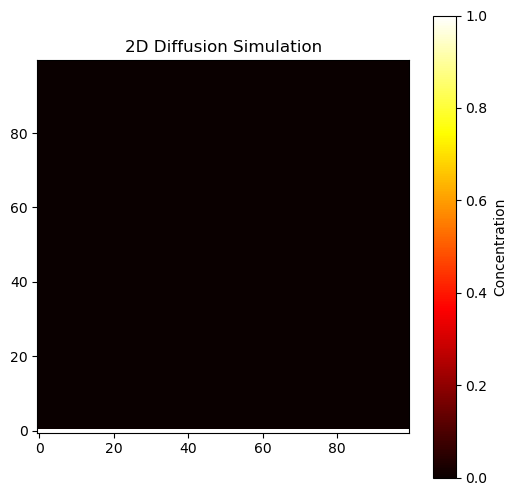

In [3]:
grid = solutions.initialize_grid(100)
num_steps = 500
visualizations.animate_2f(solutions.update(grid), grid, num_steps)
